# RT0-P0 Element for Poisson Equation in 2D

This example is to show the rate of convergence of the linear finite element approximation of the Poisson equation on the unit square:

$$- \nabla (d \nabla) u = f \; \hbox{in } (0,1)^2$$

for the following boundary conditions
- pure Dirichlet boundary condition: $u = g_D \text{ on } \partial \Omega$.
- Pure Neumann boundary condition: $d\nabla u\cdot n=g_N \text{ on } \partial \Omega$.
- mixed boundary condition: $u=g_D \text{ on }\Gamma_D, \nabla u\cdot n=g_N \text{ on }\Gamma_N.$

Find $(\sigma , u)$ in $H_{g_N,\Gamma_N}(div,\Omega)\times L^2(\Omega)$ s.t. 

$$ (d^{-1}\sigma,\tau) + (div \tau, u)  = \langle \tau \cdot n, g_D \rangle_{\Gamma_D} \quad \forall \tau \in H_{0,\Gamma_N}(div,\Omega)$$

$$ (div \sigma, v)                =  -(f,v) \quad \forall v \in L^2(\Omega) $$
 
 where 
 
 $$H_{g,\Gamma}(div,\Omega) = \{\sigma \in H(div,\Omega); \sigma \cdot n = g  \text{ on } \Gamma \subset \partial\Omega \}.$$

 The unknown $\sigma = d\nabla u$ is approximated using the lowest order Raviart-Thomas element (RT0) and $u$ by piecewise constant element (P0).

**References**


**Subroutines**:

    - PoissonRT0
    - squarePoissonRT0
    - mfemPoisson
    - PoissonRT0mfemrate
    
The method is implemented in `PoissonRT0` subroutine and tested in `squarePoissonRT0`. Together with other elements (BDM1), `mfemPoisson` provides a concise interface to solve Poisson equation in mixed formulation. The RT0-P0 element is tested in `PoissonRT0mfemrate`. This doc is based on `PoissonRT0mfemrate`.    

## RT0 Lowest Order H(div) Element in 2D

We explain degree of freedoms and basis functions for Raviart-Thomas element on a triangle. 

### Asecond orientation
The dofs and basis depends on the orientation of the mesh. We shall use the asecond orientation, i.e., `elem(t,1)< elem(t,2)< elem(t,3)` not the positive orientation. Given an `elem`, the asecond orientation can be constructed by 

        [elem,bdFlag] = sortelem(elem,bdFlag);  % ascend ordering
        
Note that `bdFlag` should be sorted as well. 

The local edge is also asecond `[2 3; 1 3; 1 2]` so that the local orientation is consistent with the global one and thus no need to deal with the sign difference when the positive oritentation is used. Read [Simplicial complex in two dimensions](../mesh/scdoc.html) for more discussion of indexing, ordering and orientation.

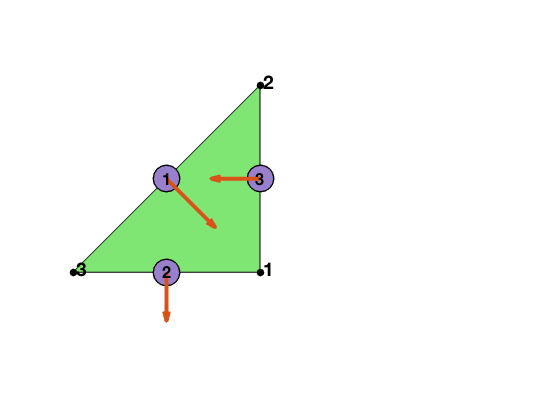

In [3]:
node = [1,0; 1,1; 0,0];
elem = [1 2 3];
edge = [2 3; 1 3; 1 2];
figure;
subplot(1,2,1)
showmesh(node,elem);
findnode(node);
findedge(node,edge,'all','rotvec');

### Local bases of RT0 element

Suppose `[i,j]` is the k-th edge. The two dimensional curl is a rotated graident defined as $\nabla^{\bot} f = (-\partial_y f, \partial _x f).$ The basis of this edge along with its divergence are given by

$$ \phi_k = \lambda_i \nabla^{\bot} \lambda_j - \lambda_j \nabla^{\bot} \lambda_i. $$

Inside one triangular, the 3 bases corresponding to 3 local edges [2 3; 1
3; 1 2] are:

$$ \phi_1 = \lambda_2 \nabla^{\bot} \lambda_3 - \lambda_3 \nabla^{\bot} \lambda_2. $$ 

$$ \phi_2 = \lambda_1 \nabla^{\bot} \lambda_3 - \lambda_3 \nabla^{\bot} \lambda_1. $$

$$ \phi_3 = \lambda_1 \nabla^{\bot} \lambda_2 - \lambda_2 \nabla^{\bot} \lambda_1. $$

The 3 dual bases are the line integral over orientated edges

$$d_i(u) = \int_{e_i} u \cdot n_i \, ds,$$

where $n_i = t_i^{\bot}$ is the rotation of the unit tangential vector of $e_i$ by $90^{\deg}$ counterclockwise.

It is straightforward to verify the "orthogonality":
$$d_i(\phi_j) = \delta_{ij}.$$

### Local to global index map

Three local edges are `locEdge = [2 3; 1 3; 1 2]`. The pointer from the local to global index can be constructured by

    [elem2dof,edge] = dofedge(elem);


elem2dof =

  8�3 uint32 matrix

    8    3    2
   11    6    5
   15   10    9
   16   13   12
    5    3    1
    7    6    4
   12   10    8
   14   13   11



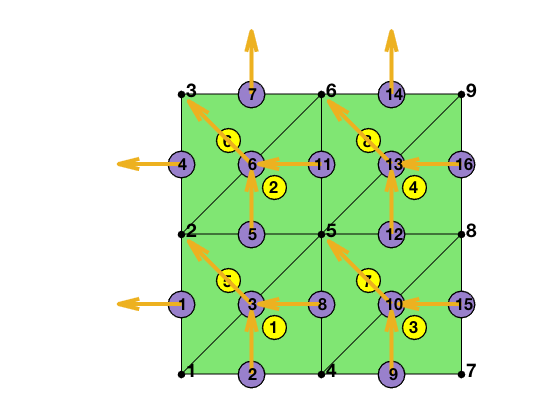

In [4]:
[node,elem] = squaremesh([0 1 0 1], 0.5);
bdFlag = setboundary(node,elem,'Dirichlet');
[elem,bdFlag] = sortelem(elem,bdFlag);
showmesh(node,elem);
findnode(node);
findelem(node,elem);
[elem2dof,edge] = dofedge(elem);
findedge(node,edge,'all','rotvec');
display(elem2dof);

## Assembling the matrix equation

We discuss several issues in the assembling.

### Mass matrix

The mass matrix can be computed by

    M = getmassmatvec(elem2edge,area,Dlambda,'RT0');

### divergence matrix

The ascend ordering orientation is not consistent with the induced orientation. The second edge would be `[3 1]` for the consistent orientation. So `[1 -1 1]` is used in the construction of div operator.

For triangle t, the basis for the constant function space is $p = 1$, the characteristic function. So in the computation of divergence operator, `elemSign` should be used to correct the sign. In the output of `gradbasis`, `-Dlambda` is always the outwards normal direction. The signed area could be negative but in the ouput, `area` is the absolute value (for the easy of integration on elements) and `elemSign` is used to record elements with negative area.

In [5]:
[Dlambda,area,elemSign] = gradbasis(node,elem);
B = icdmat(double(elem2dof),elemSign*[1 -1 1]);
display(full(B))

  Columns 1 through 13

     0     1    -1     0     0     0     0     1     0     0     0     0     0
     0     0     0     0     1    -1     0     0     0     0     1     0     0
     0     0     0     0     0     0     0     0     1    -1     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     1    -1
    -1     0     1     0    -1     0     0     0     0     0     0     0     0
     0     0     0    -1     0     1    -1     0     0     0     0     0     0
     0     0     0     0     0     0     0    -1     0     1     0    -1     0
     0     0     0     0     0     0     0     0     0     0    -1     0     1

  Columns 14 through 16

     0     0     0
     0     0     0
     0     1     0
     0     0     1
     0     0     0
     0     0     0
     0     0     0
    -1     0     0



### Boundary edges
Direction of boundary edges may not be the outwards normal direction of the domain since now `elem` is ascend orientation. `edgeSign` is introduced to record this inconsistency.

        edgeSign = ones(NE,1);
        idx = (bdFlag(:,1) ~= 0) & (elemSign == -1); % first edge is on boundary
        edgeSign(elem2edge(idx,1)) = -1;
        idx = (bdFlag(:,2) ~= 0) & (elemSign == 1);  % second edge is on boundary
        edgeSign(elem2edge(idx,2)) = -1;
        idx = (bdFlag(:,3) ~= 0) & (elemSign == -1); % third edge is on boundary
        edgeSign(elem2edge(idx,3)) = -1;

## Test Examples

### Mixed boundary condition

In [8]:
%% Setting
[node,elem] = squaremesh([0,1,0,1],0.25); 
mesh = struct('node',node,'elem',elem);
option.L0 = 1;
option.maxIt = 4;
option.printlevel = 1;
option.elemType = 'RT0';
pde = sincosNeumanndata;

Uzawa-type MultiGrid Preconditioned PCG 
#dof:      336,  #nnz:     1200, V-cycle:  1, iter: 16,   err = 6.10e-09,   time = 0.44 s
Uzawa-type MultiGrid Preconditioned PCG 
#dof:     1312,  #nnz:     4832, V-cycle:  1, iter: 16,   err = 7.58e-09,   time =  0.1 s
Uzawa-type MultiGrid Preconditioned PCG 
#dof:     5184,  #nnz:    19392, V-cycle:  1, iter: 16,   err = 9.33e-09,   time = 0.17 s
Uzawa-type MultiGrid Preconditioned PCG 
#dof:    20608,  #nnz:    77696, V-cycle:  1, iter: 16,   err = 9.13e-09,   time = 0.51 s

 #Dof       h       ||u-u_h||    ||u_I-u_h||  ||sigma-sigma_h||||sigma-sigma_h||_{div}

  336   1.25e-01   1.29904e-01   3.24734e-02   1.00431e+00   1.01710e+01
 1312   6.25e-02   6.53343e-02   8.36322e-03   5.03316e-01   5.14701e+00
 5184   3.12e-02   3.27108e-02   2.10609e-03   2.51787e-01   2.58126e+00
20608   1.56e-02   1.63607e-02   5.27476e-04   1.25909e-01   1.29160e+00

 #Dof   Assemble     Solve      Error      Mesh    

  336   1.20e-01   4.40e-01   1.20e-01   

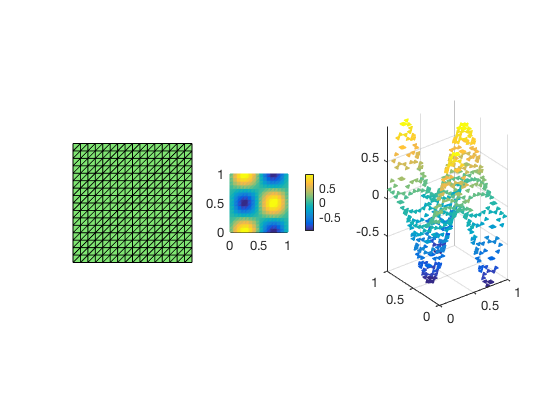

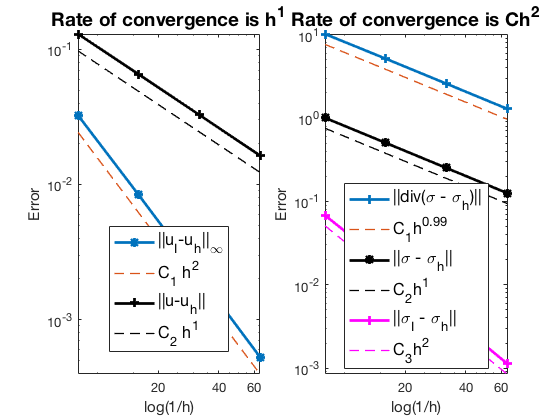

In [9]:
%% Mix Dirichlet and Neumann boundary condition.
option.solver = 'uzawapcg';
mesh.bdFlag = setboundary(node,elem,'Dirichlet','~(x==0)','Neumann','x==0');
mfemPoisson(mesh,pde,option);

### Pure Neumann boundary condition

In mixed formulation，the Neumann boundary condition for $d\nabla u$ becomes the Dirichlet boundary condiiton for $\sigma$. The space for $u$ is $L^2_0$ and thus one dof should be removed to have a non-singular system.

Uzawa-type MultiGrid Preconditioned PCG 
#dof:      336,  #nnz:     1102, V-cycle:  1, iter: 16,   err = 3.20e-09,   time = 0.15 s
Uzawa-type MultiGrid Preconditioned PCG 
#dof:     1312,  #nnz:     4638, V-cycle:  1, iter: 17,   err = 3.67e-09,   time = 0.04 s
Uzawa-type MultiGrid Preconditioned PCG 
#dof:     5184,  #nnz:    19006, V-cycle:  1, iter: 18,   err = 3.25e-09,   time = 0.19 s
Uzawa-type MultiGrid Preconditioned PCG 
#dof:    20608,  #nnz:    76926, V-cycle:  1, iter: 18,   err = 8.29e-09,   time = 0.47 s

 #Dof       h       ||u-u_h||    ||u_I-u_h||  ||sigma-sigma_h||||sigma-sigma_h||_{div}

  336   1.25e-01   1.35274e-01   4.88517e-02   1.00659e+00   1.01710e+01
 1312   6.25e-02   6.55354e-02   1.00318e-02   5.03633e-01   5.14701e+00
 5184   3.12e-02   3.27194e-02   2.33376e-03   2.51827e-01   2.58126e+00
20608   1.56e-02   1.63613e-02   5.71884e-04   1.25914e-01   1.29160e+00

 #Dof   Assemble     Solve      Error      Mesh    

  336   6.00e-02   1.50e-01   3.00e-02   

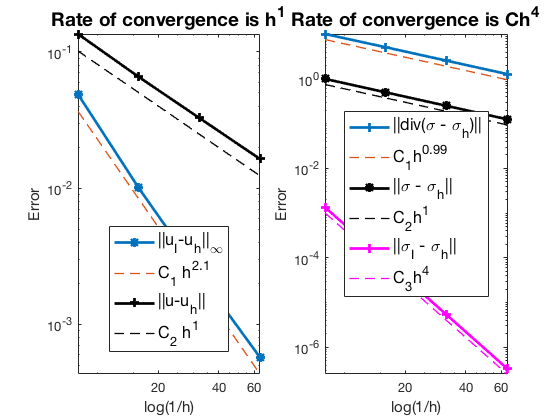

In [10]:
option.plotflag = 0;
mesh.bdFlag = setboundary(node,elem,'Neumann');
mfemPoisson(mesh,pde,option);

### Pure Dirichlet boundary condition

Uzawa-type MultiGrid Preconditioned PCG 
#dof:      336,  #nnz:     1232, V-cycle:  1, iter: 16,   err = 3.60e-09,   time = 0.09 s
Uzawa-type MultiGrid Preconditioned PCG 
#dof:     1312,  #nnz:     4896, V-cycle:  1, iter: 16,   err = 6.53e-09,   time = 0.05 s
Uzawa-type MultiGrid Preconditioned PCG 
#dof:     5184,  #nnz:    19520, V-cycle:  1, iter: 16,   err = 8.34e-09,   time = 0.16 s
Uzawa-type MultiGrid Preconditioned PCG 
#dof:    20608,  #nnz:    77952, V-cycle:  1, iter: 16,   err = 8.49e-09,   time = 0.43 s

 #Dof       h       ||u-u_h||    ||u_I-u_h||  ||sigma-sigma_h||||sigma-sigma_h||_{div}

  336   1.25e-01   1.29702e-01   3.08718e-02   1.00257e+00   1.01710e+01
 1312   6.25e-02   6.53059e-02   7.92226e-03   5.03081e-01   5.14701e+00
 5184   3.12e-02   3.27071e-02   1.99320e-03   2.51757e-01   2.58126e+00
20608   1.56e-02   1.63602e-02   4.99086e-04   1.25905e-01   1.29160e+00

 #Dof   Assemble     Solve      Error      Mesh    

  336   1.00e-02   9.00e-02   1.00e-02   

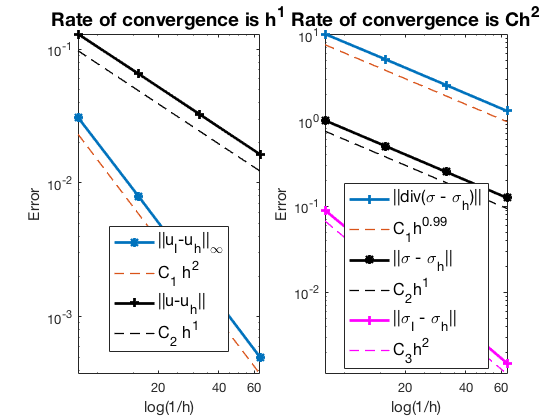

In [11]:
%% Pure Dirichlet boundary condition.
mesh.bdFlag = setboundary(node,elem,'Dirichlet');
mfemPoisson(mesh,pde,option);

## Conclusion

The optimal rates of convergence for $u$ and $\sigma$ are observed, namely, 1st order for L2 norm of u, L2 norm of $\sigma$ and H(div) norm of $\sigma$. The 2nd order convergent rates between two discrete functions $\|u_I - u_h\|$ and $\|\sigma_I - \sigma_h\|$ are known as superconvergence.

Triangular preconditioned GMRES (the default solver) and Uzawa preconditioned CG converges uniformly in all cases. Traingular preconditioner is two times faster than PCG although GMRES is used.